## Gather Character Data from .ttf Files

In [1]:
from PIL import Image, ImageDraw, ImageFont
import os, sys, shutil
from pathlib import Path
import glob

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [3]:
import tensorflow
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import initializers

In [4]:
#constants
width, height = (224, 224)
random_dim = 100
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#character set dictionary
#limited to uppercase, lowercase and digits only
charset = {
    'Aa': 'A',
    'Bb': 'B',
    'Cc': 'C',
    'Dd': 'D',
    'Ee': 'E',
    'Ff': 'F',
    'Gg': 'G',
    'Hh': 'H',
    "Ii": 'I',
    'Jj': 'J',
    'Kk': 'K',
    'Ll': 'L',
    'Mm': 'M',
    'Nn': 'N',
    'Oo': 'O',
    'Pp': 'P',
    'Qq': 'Q',
    'Rr': 'R',
    'Ss': 'S',
    'Tt': 'T',
    'Uu': 'U',
    'Vv': 'V',
    'Ww': 'W',
    'Xx': 'X',
    'Yy': 'Y',
    'Zz': 'Z',
    'a': 'a',
    'b': 'b',
    'c': 'c',
    'd': 'd',
    'e': 'e',
    'f': 'f',
    'g': 'g',
    'h': 'h',
    'i': 'i',
    'j': 'j',
    'k': 'k',
    'l': 'l',
    'm': 'm',
    'n': 'n',
    'o': 'o',
    'p': 'p',
    'q': 'q',
    'r': 'r',
    's': 's',
    't': 't',
    'u': 'u',
    'v': 'v',
    'w': 'w',
    'x': 'x',
    'y': 'y',
    'z': 'z',
    '0': '0',
    '1': '1',
    '2': '2',
    '3': '3',
    '4': '4',
    '5': '5',
    '6': '6',
    '7': '7',
    '8': '8',
    '9': '9'
}

***Note:*** Run the below cell 4 times.   

In [70]:
#loop with 4 font folders to avoid timeout
#'fonts_A-G/'
#'fonts_H-M/'
#'fonts_N-S/'
#'fonts_T-Z/'

for filepath in glob.glob('fonts_T-Z/**/*.ttf', recursive=True):
    path = filepath
    dirname = Path(filepath).stem
    os.mkdir('data/{}'.format(dirname))
    fontname = path.split('/')[-1]
    font = ImageFont.truetype(fontname, 224, encoding='utf-8')
    
    for c in charset:
        image = Image.new("RGB", (width, height), "black")
        draw = ImageDraw.Draw(image)
        offset_w, offset_h = font.getoffset(charset[c])
        w, h = draw.textsize(charset[c], font=font)
        pos = ((width-w-offset_w)/2, (height-h-offset_h)/2)
    
        #draw and save
        draw.text(pos, charset[c], "white", font=font)
        image.save("data/{}/{}.png".format(dirname, c))

## Organize the Dataset

In [71]:
#make a folder for each class
folder='classes/'
classes=charset.keys()

for c in classes:
    os.mkdir('classes/{}'.format(c))

#loop through each font folder and each image in the folder
for filepath in glob.glob('data/**/*.png', recursive=True):
    path = filepath
    classname = Path(filepath).stem
    fontname = path.split('/')[1]
    filename = fontname + '_' + path.split('/')[-1]

    #move to class folder based on the filename
    shutil.move(path, 'classes/{}/{}'.format(classname, filename))

In [5]:
#inspect the class order
class_folders = os.listdir('classes/')
class_folders.remove('.DS_Store')
class_folders

['Uu',
 'Yy',
 'Pp',
 'Bb',
 'Nn',
 'Gg',
 'Kk',
 'Ii',
 'Ee',
 'Ll',
 'r',
 'u',
 '9',
 '0',
 '7',
 'Rr',
 'i',
 'n',
 'g',
 '6',
 'z',
 '1',
 '8',
 't',
 's',
 'a',
 'f',
 'o',
 'h',
 'Ww',
 'Ss',
 'Vv',
 'Zz',
 'Dd',
 'Hh',
 'Aa',
 'Mm',
 'Oo',
 'Cc',
 'Jj',
 'Ff',
 'm',
 'j',
 'c',
 'Xx',
 'Tt',
 'd',
 'v',
 'q',
 '4',
 'x',
 '3',
 'e',
 'b',
 'k',
 'l',
 '2',
 'y',
 '5',
 'p',
 'Qq',
 'w']

## Process The Dataset

### Helpers

In [6]:
def show_image_grid(image_list, nrows, ncols, label_list=None, show_labels=False, savename=None, figsize=(10,10), showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[list(y[i]).index(1)])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

### Process the Image Batches

In [7]:
datagen = ImageDataGenerator(rescale=1/255)
datagenerator = datagen.flow_from_directory('classes/', target_size=(224, 224), batch_size=240, color_mode='grayscale', shuffle=True, class_mode='categorical', classes=class_folders)

Found 239630 images belonging to 62 classes.


In [8]:
print('Number of samples: ', datagenerator.samples)
print('Number of classes: ', len(datagenerator.class_indices))
print('Number of samples per class: ', int(datagenerator.samples/len(datagenerator.class_indices)))

Number of samples:  239630
Number of classes:  62
Number of samples per class:  3865


In [9]:
print(datagenerator.class_indices)

{'Uu': 0, 'Yy': 1, 'Pp': 2, 'Bb': 3, 'Nn': 4, 'Gg': 5, 'Kk': 6, 'Ii': 7, 'Ee': 8, 'Ll': 9, 'r': 10, 'u': 11, '9': 12, '0': 13, '7': 14, 'Rr': 15, 'i': 16, 'n': 17, 'g': 18, '6': 19, 'z': 20, '1': 21, '8': 22, 't': 23, 's': 24, 'a': 25, 'f': 26, 'o': 27, 'h': 28, 'Ww': 29, 'Ss': 30, 'Vv': 31, 'Zz': 32, 'Dd': 33, 'Hh': 34, 'Aa': 35, 'Mm': 36, 'Oo': 37, 'Cc': 38, 'Jj': 39, 'Ff': 40, 'm': 41, 'j': 42, 'c': 43, 'Xx': 44, 'Tt': 45, 'd': 46, 'v': 47, 'q': 48, '4': 49, 'x': 50, '3': 51, 'e': 52, 'b': 53, 'k': 54, 'l': 55, '2': 56, 'y': 57, '5': 58, 'p': 59, 'Qq': 60, 'w': 61}


In [10]:
X, y = next(datagenerator)

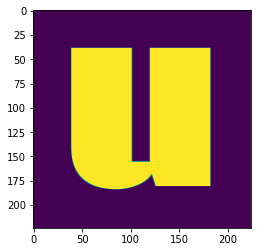

In [14]:
#Take a look at the image data
#test_image = datagenerator[0][0][0]
test_image = X[10]
plt.imshow(test_image)
plt.show()

In [15]:
#Ensure the classes line up
y_index = list(y[10]).index(1)
print('The above image is from class: {}'.format(class_folders[y_index]))

The above image is from class: u


### Inspect the Data

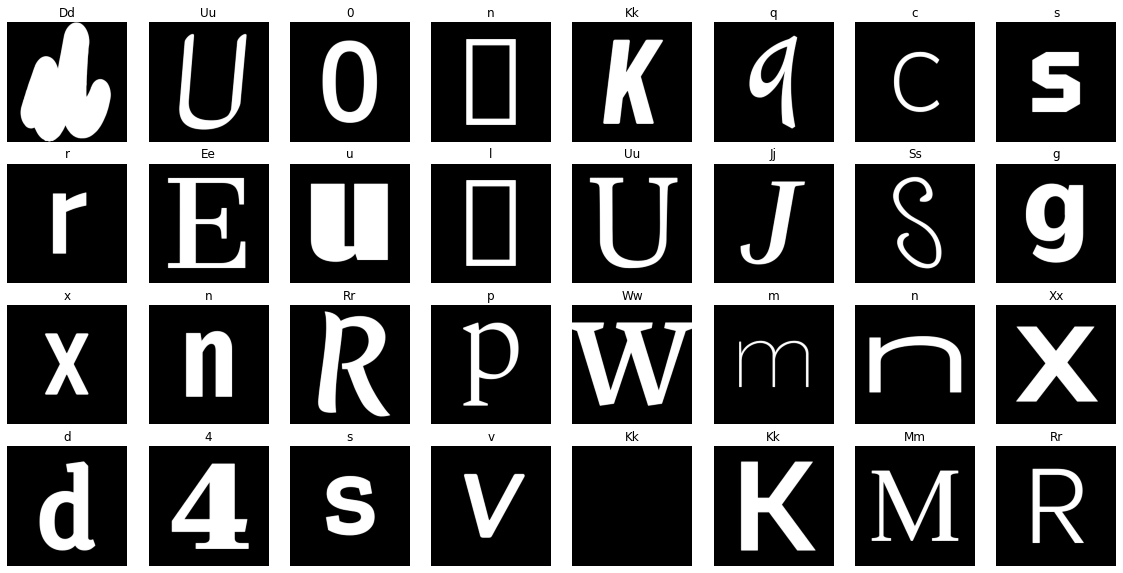

In [16]:
show_image_grid(X, 4, 8, label_list=class_folders, show_labels=True, figsize=(20,10), savename='./images/image_grid.png')

***Observation:*** Looks like there are a few unreadable characters (displayed as squares and blanks).   
These duplicate characters should be filtered out as part of the data cleaning process.

### Assemble DataFrame

In [17]:
df_image_arrays = []
df_classes = []
df_class_idx = []

iter_count = 0

In [18]:
#Pre-Dataframe helper function
#Run this 1000 times to fully populate the arrays

for i in range(len(datagenerator.next()[0])):
    df_image_arrays.append(datagenerator[0][0][i])
    idx = list(datagenerator[0][1][i]).index(1)
    df_class_idx.append(idx)
    df_classes.append(class_folders[idx])

iter_count += 1
print(iter_count)

1


In [19]:
print(df_classes[19])

p


In [20]:
print(df_class_idx[19])

59


In [21]:
df_image_arrays[19]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

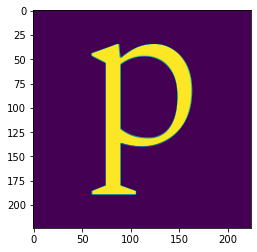

In [22]:
#Take a look at the large batch image data
plt.imshow(df_image_arrays[19])
plt.show()

In [23]:
font_df = pd.DataFrame(df_class_idx, columns=['class'])

In [24]:
font_df['class_name'] = df_classes

In [25]:
font_df['image_matrix'] = df_image_arrays

In [26]:
font_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class         240 non-null    int64 
 1   class_name    240 non-null    object
 2   image_matrix  240 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


In [27]:
font_df.head()

,class,class_name,image_matrix
0,33,Dd,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,0,Uu,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,13,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,17,n,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,6,Kk,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


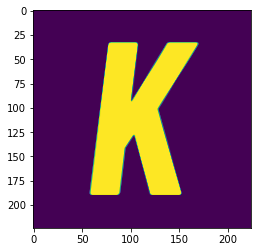

In [28]:
plt.imshow(font_df.at[4, 'image_matrix'])
plt.show()

## EDA

### Explore the Images

In [29]:
#Averaging the images
def find_mean_char(img_matricies, size=(224, 224)):
    #calculate the average
    mean_img = np.mean(img_matricies, axis=0)
    #reshape into matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, cmap='Greys_r')
    plt.title('Average Character')
    plt.axis('off')
    plt.show()
    return mean_img

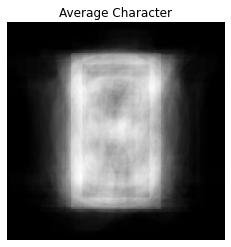

In [30]:
#all chars
mean_char = find_mean_char(font_df["image_matrix"].tolist())

In [34]:
#Averaging specific images in the batch
def find_mean_img(img_class, size=(224, 224)):
    #calculate the average
    char_df = font_df[font_df['class_name']==img_class]
            
    mean_img = np.mean(char_df['image_matrix'], axis=0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, cmap='Greys_r')
    plt.title(f'Average {img_class}')
    plt.axis('off')
    plt.show()
    #return mean_img

In [31]:
lower_ts = font_df[font_df['class_name']=="t"]

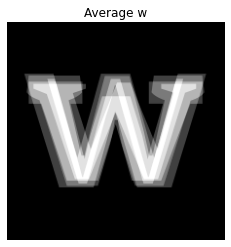

In [35]:
#average of the lowercase ws
find_mean_img('w')

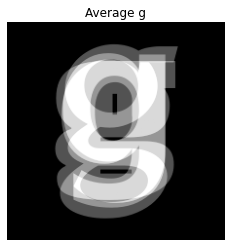

In [40]:
find_mean_img('g')

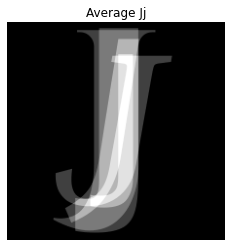

In [43]:
find_mean_img('Jj')

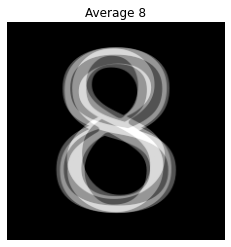

In [44]:
find_mean_img('8')

### Ensure the Classes are Balanced

In [49]:
#all should contain 3865 images
for folder in class_folders:
    onlyfiles = next(os.walk('classes/{}'.format(folder)))[2]
    print('{}:{}'.format(folder, len(onlyfiles)))

Uu:3865
Yy:3865
Pp:3865
Bb:3865
Nn:3865
Gg:3865
Kk:3865
Ii:3865
Ee:3865
Ll:3865
r:3865
u:3865
9:3865
0:3865
7:3865
Rr:3865
i:3865
n:3865
g:3865
6:3865
z:3865
1:3865
8:3865
t:3865
s:3865
a:3865
f:3865
o:3865
h:3865
Ww:3865
Ss:3865
Vv:3865
Zz:3865
Dd:3865
Hh:3865
Aa:3865
Mm:3865
Oo:3865
Cc:3865
Jj:3865
Ff:3865
m:3865
j:3865
c:3865
Xx:3865
Tt:3865
d:3865
v:3865
q:3865
4:3865
x:3865
3:3865
e:3865
b:3865
k:3865
l:3865
2:3865
y:3865
5:3865
p:3865
Qq:3865
w:3865


In [52]:
#save state for later
font_df.to_csv('csv/fonts.csv')